In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Get the Data

In [2]:
train = pd.read_csv('/kaggle/input/fi-optimun-frecuency/merged_2.csv', sep=';')

Samples has serveral Thickness

In [3]:
train['Thickness (mm)'].value_counts().index

Index([0.04, 0.1, 0.07, 1.85, 0.2, 3.0, 2.05, 0.36, 0.29, 0.0, 0.57, 2.25], dtype='float64', name='Thickness (mm)')

## Convert the data to a format you can easily manipulate

In [4]:
train = train.rename(columns = {'Sample':'target'})
train = pd.concat([train[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']],train[['target']]], axis=1)


Remove *Thickness (mm)*

In [5]:
train.head()

,Frequency (GHz),LG (mV),HG (mV),target
0,100.0,-7.080942,-0.854611,A1
1,100.0,67.024785,0.244141,A1
2,100.0,124.893178,-1.098776,A1
3,100.0,91.075571,0.000000,A1
4,100.0,48.956174,0.122094,A1


## Sample a test set, put it aside, and never look at it
Data is split in a stratified fashion, using this at  theTarget as  class labels  
**Conjecture**: It is assumed that there is time independence in the laser measurement..

In [6]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(train, test_size=0.2, random_state=42, stratify=train.target)


Check the target distribution of target in a plotted bar. The frequency or proportion are uniform in train and test dataset

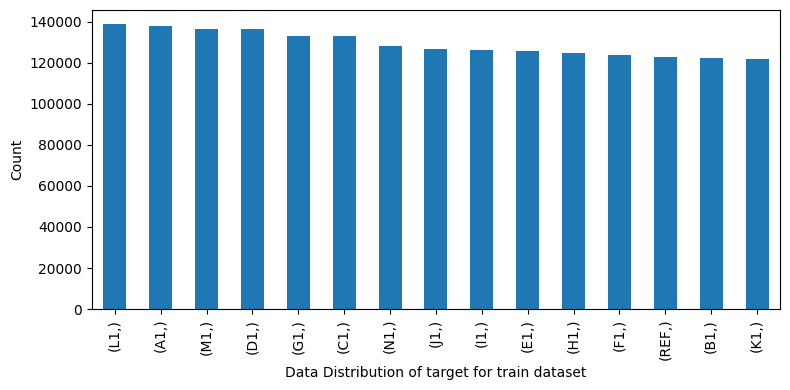

In [7]:
import matplotlib.pylab as plt
ax = train_set[['target']].value_counts().transpose().plot.bar(figsize=(8, 4), legend=False)
ax.set_xlabel('Data Distribution of target for train dataset')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

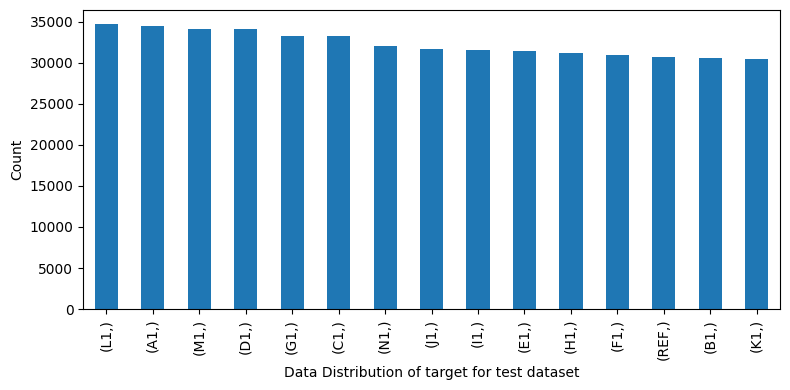

In [8]:
ax = test_set[['target']].value_counts().transpose().plot.bar(figsize=(8, 4), legend=False)
ax.set_xlabel('Data Distribution of target for test dataset')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

 # Explore the data

In [9]:
train_ex = train_set.copy()

In [10]:
train_ex.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1936500 entries, 1125297 to 2139800
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Frequency (GHz)  float64
 1   LG (mV)          float64
 2   HG (mV)          float64
 3   target           object 
dtypes: float64(3), object(1)
memory usage: 73.9+ MB


There are 15 types of plastics materials are measured

In [11]:
train_ex['target'].nunique()

15

In [12]:
train_ex['Frequency (GHz)'].nunique()

51

## Identify the promising transformations you may want to apply
Target variable takes only a limited number of values. Encode target (categorical features) as an integer array.  
**Question**: How does doing this in the previous phase (Convert the data to a format you can easily manipulate) affect the classifier?

In [13]:
from sklearn.preprocessing import OrdinalEncoder
label_train_ex = train_ex.copy()
ordinal_encoder = OrdinalEncoder()
label_train_ex['target'] = ordinal_encoder.fit_transform(train_ex[['target']])

### % of missing values
No missing values in each column of training data

In [14]:
print(label_train_ex.shape)
missing_val_count_by_column = (label_train_ex.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(1936500, 4)
Series([], dtype: int64)


### Type of distribution in frecuency
Representation of the distribution of nums of sample by frecuency. 

In [15]:
label_train_ex['Frequency (GHz)'].nunique()

51

In [16]:
label_train_ex['Frequency (GHz)'].value_counts().sort_index().index

Index([100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0,
       200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0,
       300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0,
       400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0,
       500.0, 510.0, 520.0, 530.0, 540.0, 550.0, 560.0, 570.0, 580.0, 590.0,
       600.0],
      dtype='float64', name='Frequency (GHz)')

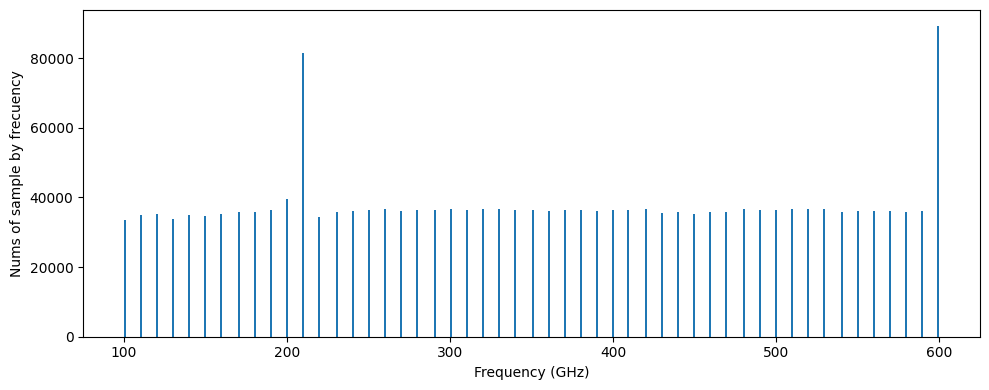

In [17]:
ax = label_train_ex['Frequency (GHz)'].plot.hist(figsize=(10, 4), bins=408)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Nums of sample by frecuency')
plt.tight_layout()
plt.show()

### Balanced samples of frecuency 

In [18]:
label_train_ex.head()

,Frequency (GHz),LG (mV),HG (mV),target
1125297,560.0,1.220852,39.067268,6.0
2316280,260.0,6.836772,-0.244164,14.0
10093,130.0,33.207178,-0.244141,0.0
206305,210.0,13.307288,-0.122023,1.0
2031157,390.0,0.488341,633.622336,12.0


In [19]:
mode = label_train_ex.groupby(['target', 'Frequency (GHz)']).size().mode()[0]


**Doubts**: 
* Show 2423 your mode is 2350
* Why use the mode and not min

In [20]:
# Function to reduce samples to the mode value
def reduce_to_mode(df, target, frequency, mode):
    # Filter the DataFrame for the specific sample and frequency
    freq_df = df[(df['target'] == target) & (df['Frequency (GHz)'] == frequency)]
    # If the number of samples is greater than the mode, sample down to the mode
    if len(freq_df) > mode:
        return freq_df.sample(n=mode, random_state=42)
    return freq_df

# Apply the function to reduce target for each combination of Sample and Frequency (GHz)
tmp_balanced_data = []
for (target, frequency), group in label_train_ex.groupby(['target', 'Frequency (GHz)']):
    tmp_balanced_data.append(reduce_to_mode(label_train_ex, target, frequency, mode))

# Combine the balanced samples into a single DataFrame
balanced_train_ex = pd.concat(tmp_balanced_data)

Count values within each target and frequency

In [21]:
grouped = balanced_train_ex.groupby(['target', 'Frequency (GHz)'])
grouped.count()

LG (mV)  HG (mV)
target Frequency (GHz)                  
0.0    100.0               2173     2173
       110.0               2192     2192
       120.0               2423     2423
       130.0               2413     2413
       140.0               2423     2423
...                         ...      ...
14.0   560.0               2423     2423
       570.0               2423     2423
       580.0               2423     2423
       590.0               2423     2423
       600.0               2423     2423

[765 rows x 2 columns]

**Doubts**: 
* There are several targets with samples below of mode, i.e: 100.0 Ghz, 130.0 Ghz. How affect `Thickness (mm)` attribute to study.

 ## Study the correlations between attributes

Encodes target labels with values between 0 and ``n_classes-1, so `A1` are `0`, `B1` are `1`,... and so on all categories

`A1`, `B1`, `C1`, `D1`, `E1`, `E2`, `E3`, `F1`, `G1`, `H1`, `I1`, `J1`, `K1`, `L1`, `M1`, `N1`, `REF`

In [22]:
balanced_train_ex.head()

,Frequency (GHz),LG (mV),HG (mV),target
829,100.0,56.281285,0.488329,0.0
2337,100.0,54.938348,-0.244236,0.0
1086,100.0,79.233307,1.098752,0.0
1333,100.0,41.997313,-1.587033,0.0
1854,100.0,62.629715,-0.854588,0.0


It is start to analice PE/tie/EVOH/tie/PE/Adhesivo/PE/tie/EVOH/tie/PE (0.2mm) `A1` category `0`

In [23]:
df_tmp = label_train_ex[label_train_ex.target==0]

In [24]:
df_tmp['Frequency (GHz)'].value_counts(sort=False).sort_index()


Frequency (GHz)
100.0     2173
110.0     2192
120.0     2447
130.0     2413
140.0     2487
150.0     2434
160.0     2465
170.0     2466
180.0     2454
190.0     2454
200.0     2521
210.0    12832
220.0     2351
230.0     2489
240.0     2474
250.0     2483
260.0     2517
270.0     2167
280.0     2502
290.0     2513
300.0     2502
310.0     2429
320.0     2507
330.0     2456
340.0     2452
350.0     2449
360.0     2471
370.0     2465
380.0     2490
390.0     2455
400.0     2501
410.0     2455
420.0     2429
430.0     2480
440.0     2405
450.0     2281
460.0     2289
470.0     2286
480.0     2299
490.0     2415
500.0     2404
510.0     2505
520.0     2421
530.0     2430
540.0     1968
550.0     2448
560.0     2437
570.0     2421
580.0     2367
590.0     2447
600.0     6484
Name: count, dtype: int64

**Question**: It seems that the samples are not balanced for each frequency. How does this affect the correlation?

In [25]:
label_train_ex.columns.to_list()

['Frequency (GHz)', 'LG (mV)', 'HG (mV)', 'target']

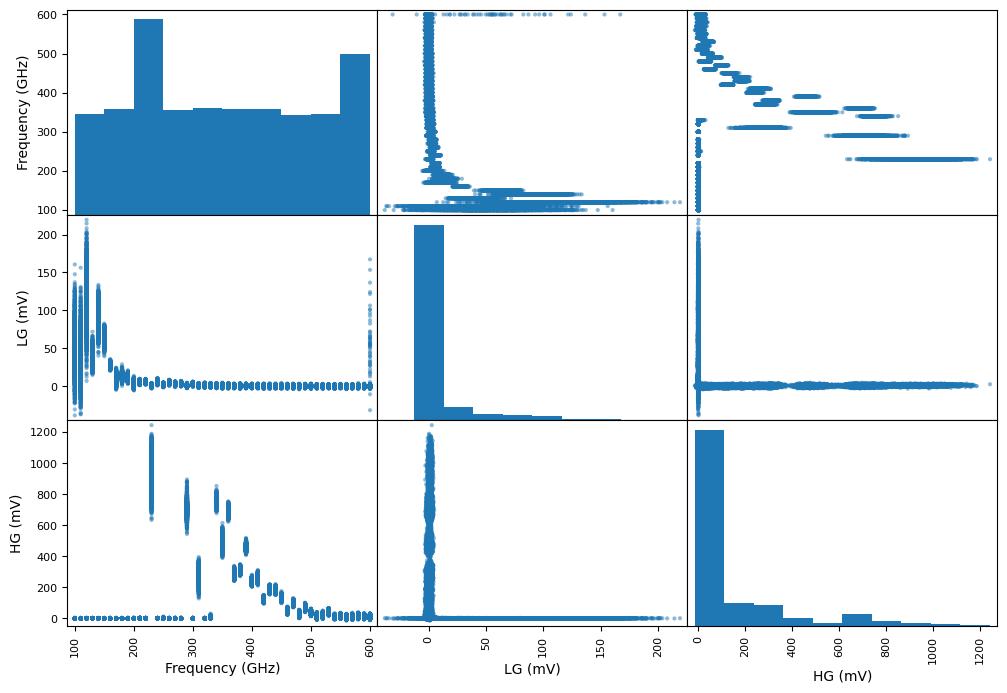

In [26]:
from pandas.plotting import scatter_matrix
attributes = ['Frequency (GHz)', 'LG (mV)', 'HG (mV)']
ax = scatter_matrix(df_tmp[attributes], figsize=(12, 8))

In [27]:
corr_matrix = df_tmp.corr()
corr_matrix['Frequency (GHz)'].sort_values(ascending=False)

Frequency (GHz)    1.000000
HG (mV)            0.022222
LG (mV)           -0.518078
target                  NaN
Name: Frequency (GHz), dtype: float64

**Insights**: The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the `HG (mV)` value tends to go up slightly when the `Frequency (GHz)` goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a big negative correlation between `LG (mV)` and the `Frequency (GHz)` 

**Evidende**: It can be interpreted that to measured plastic PE/tie/EVOH/tie/PE/Adhesivo/PE/tie/EVOH/tie/PE (0.2mm) `A1` category `0` getaworse response to since high frecuencies in the `LG (mV)`. So the measurement obtained in the low-pass filter is lower `LG (mV)` is better to low frecuencies, although it obtains response peaks at 600 GHz that would have to be explained why they occur


7oat64

# Prepare the data to better expose the underlying data patterns

## Feature engineering
### Add promising transformations of features

In [28]:
train_pr = balanced_train_ex.copy()
train_pr = train_pr.rename(columns = {'Frequency (GHz)':'freq'})

In [29]:
train_pr = train_pr.astype({"freq": int, "target": int})

#https://stackoverflow.com/questions/43131715/pandas-new-column-by-combining-numbers-of-two-columns-as-strings
train_pr['freq_target'] = train_pr['freq'].astype(str) + train_pr['target'].astype(str)
train_pr['freq_target'].nunique() # train_pr['freq'].nunique() * train_pr['target'].nunique() 765 different measures



765

In [30]:
train_pr['freq_target'] = train_pr['freq_target'].astype(int)
train_pr = train_pr.rename(columns = {'freq':'Frequency (GHz)'})

**Doubts**: Normalize freq_target?

In [31]:
train_pr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1813690 entries, 829 to 2417599
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Frequency (GHz)  int64  
 1   LG (mV)          float64
 2   HG (mV)          float64
 3   target           int64  
 4   freq_target      int64  
dtypes: float64(2), int64(3)
memory usage: 83.0 MB


# Explore different models

In [32]:
train_mo = train_pr.copy()
train_mo = train_mo.sample(frac=0.02, random_state=1)
train_mo.head()

,Frequency (GHz),LG (mV),HG (mV),target,freq_target
1334622,220,4.761323,0.854635,8,2208
1081647,410,2.075449,285.923588,6,4106
1099242,470,-0.122085,57.380050,6,4706
1770792,120,48.223659,-1.220822,11,12011
1496902,230,2.197534,630.325967,9,2309


In [33]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(train_mo, test_size=0.2, random_state=42, stratify=train_mo.freq_target)

y_tr = train_set.target
y_va = test_set[['target']]

X_tr = train_set.drop(columns=['target'])
X_va = test_set.drop(columns=['target'])

In [34]:
grouped = train_set.groupby(['target', 'Frequency (GHz)'])
grouped.count()['freq_target']

target  Frequency (GHz)
0       100                34
        110                36
        120                38
        130                39
        140                32
                           ..
14      560                45
        570                38
        580                41
        590                35
        600                51
Name: freq_target, Length: 765, dtype: int64

**Cojeture**: Look samples are homogenius

In [35]:
grouped = test_set.groupby(['target', 'Frequency (GHz)'])
grouped.count()['freq_target']

target  Frequency (GHz)
0       100                 9
        110                 9
        120                10
        130                10
        140                 8
                           ..
14      560                11
        570                10
        580                10
        590                 9
        600                13
Name: freq_target, Length: 765, dtype: int64

In [36]:
X_va_freq_target = X_va.copy()
X_tr, X_va = X_tr.drop(columns=['freq_target']), X_va.drop(columns=['freq_target'])

## Train many quick and dirty models 

In [37]:
import time
start_time = time.time()

In [38]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_tr.to_numpy(), y_tr.to_numpy())
y_pred = dummy_clf.predict(X_va.to_numpy())

from sklearn.metrics import accuracy_score
dummy_score = accuracy_score(y_va.target.to_numpy(), y_pred)

In [39]:
from sklearn.linear_model import LogisticRegression
logit_clf = LogisticRegression().fit(X_tr.to_numpy(), y_tr.to_numpy())
y_pred = logit_clf.predict(X_va.to_numpy())
logit_score = accuracy_score(y_va.target.to_numpy(), y_pred)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier().fit(X_tr.to_numpy(), y_tr.to_numpy())
y_pred = sgd_clf.predict(X_va.to_numpy())
sgd_score = accuracy_score(y_va.target.to_numpy(), y_pred)

In [41]:
from sklearn.svm import SVC
svc_clf = SVC().fit(X_tr.to_numpy(), y_tr.to_numpy())
y_pred = svc_clf.predict(X_va.to_numpy())
svc_score = accuracy_score(y_va.target.to_numpy(), y_pred)

In [42]:
bayes_score=0
from sklearn.naive_bayes import MultinomialNB
#bayes_clf = MultinomialNB().fit(X_tr.to_numpy(), y_tr.to_numpy())
#bayes_score = accuracy_score(y_va.target.to_numpy(), y_pred)

# ValueError: Negative values in data passed to MultinomialNB (input X)

In [43]:
from sklearn.linear_model import RidgeClassifier
ridge_clf = RidgeClassifier().fit(X_tr.to_numpy(), y_tr.to_numpy())
y_pred = ridge_clf.predict(X_va.to_numpy())
ridge_score = accuracy_score(y_va.target.to_numpy(), y_pred)

In [44]:
from sklearn.neighbors import KNeighborsClassifier
neigh_clf = KNeighborsClassifier().fit(X_tr.to_numpy(), y_tr.to_numpy())
y_pred = neigh_clf.predict(X_va.to_numpy())
neigh_score = accuracy_score(y_va.target.to_numpy(), y_pred)

In [45]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier().fit(X_tr.to_numpy(), y_tr.to_numpy())
y_pred = tree_clf.predict(X_va.to_numpy())
tree_score = accuracy_score(y_va.target.to_numpy(), y_pred)

In [46]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier().fit(X_tr.to_numpy(), y_tr.to_numpy())
y_pred = rnd_clf.predict(X_va.to_numpy())
rnd_score = accuracy_score(y_va.target.to_numpy(), y_pred)

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier().fit(X_tr.to_numpy(), y_tr.to_numpy())
y_pred = gb_clf.predict(X_va.to_numpy())
gb_score = accuracy_score(y_va.target.to_numpy(), y_pred)

In [48]:
run_time = time.time() - start_time
print(f"Run Time: {run_time:.2f}s")


Run Time: 129.22s


In [49]:

lst_accuracy_score = [bayes_score, dummy_score, gb_score, logit_score, neigh_score, ridge_score, rnd_score, sgd_score, svc_score, tree_score]
lst_name_clf = ['bayes', 'dummy', 'gb', 'logit', 'neigh', 'ridge', 'rnd', 'sgd', 'svc', 'tree' ]


df_scores = pd.DataFrame({
"name_clf" : lst_name_clf,
"accuracy_score" : lst_accuracy_score
})

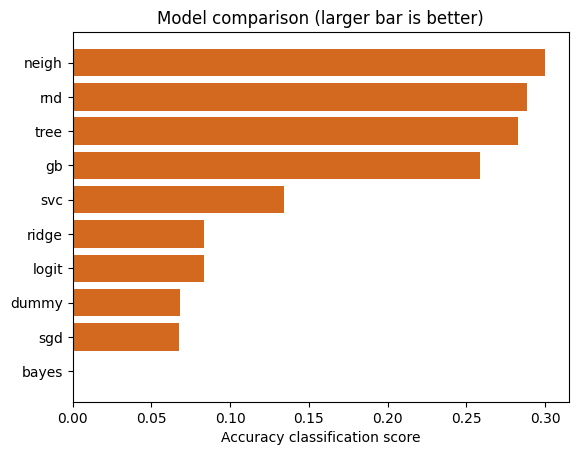

In [50]:
df_scores.sort_values('accuracy_score', ascending=True, inplace=True)
plt.barh(np.arange(len(lst_name_clf)), df_scores.accuracy_score, color='chocolate')
plt.yticks(np.arange(len(lst_name_clf)), df_scores.name_clf)
#plt.xlim(0, 1.2)
plt.title('Model comparison (larger bar is better)')
plt.xlabel('Accuracy classification score')
plt.show()

# Present your solution

## Present your solution.

In [51]:
lst_target = test_set['target'].drop_duplicates().sort_values().values.tolist()
lst_freq = test_set['Frequency (GHz)'].drop_duplicates().sort_values().values.tolist()

In [52]:
train_sol = train_mo.copy()
train_sol.head()

,Frequency (GHz),LG (mV),HG (mV),target,freq_target
1334622,220,4.761323,0.854635,8,2208
1081647,410,2.075449,285.923588,6,4106
1099242,470,-0.122085,57.380050,6,4706
1770792,120,48.223659,-1.220822,11,12011
1496902,230,2.197534,630.325967,9,2309


Evaluate the accuracy of a classification of the best classificator

In [62]:
y_pred = neigh_clf.predict(X_va.to_numpy())

In [63]:
y_va_sol = y_va.copy() 
y_va_sol['y_pred'] = y_pred 
# df['test'] = np.where(df['crnn_pred']==df['manual_raw_value'], 1, 0)
y_va_sol['true_pred'] = np.where(y_va_sol['y_pred'] == y_va_sol['target'],1,0)
X_va_freq = pd.concat([y_va_sol,X_va_freq_target['Frequency (GHz)']], axis=1)

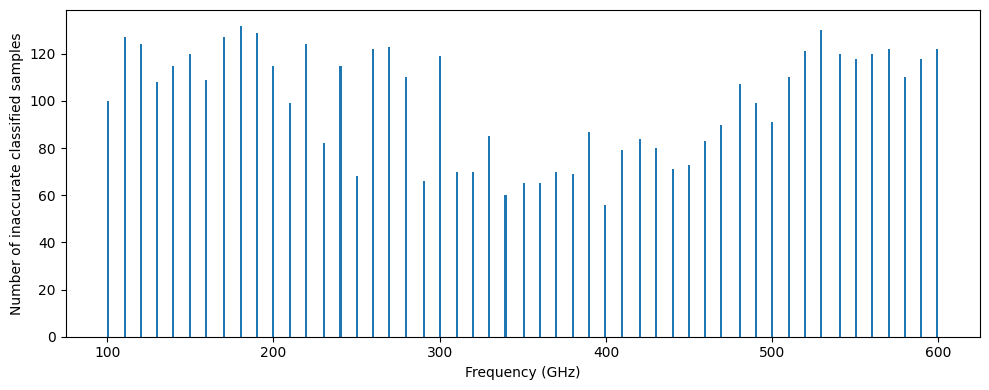

In [64]:
ax = X_va_freq[X_va_freq.true_pred==0]['Frequency (GHz)'].plot.hist(bins=408,figsize=(10, 4))
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Number of inaccurate classified samples')
plt.tight_layout()
plt.show()

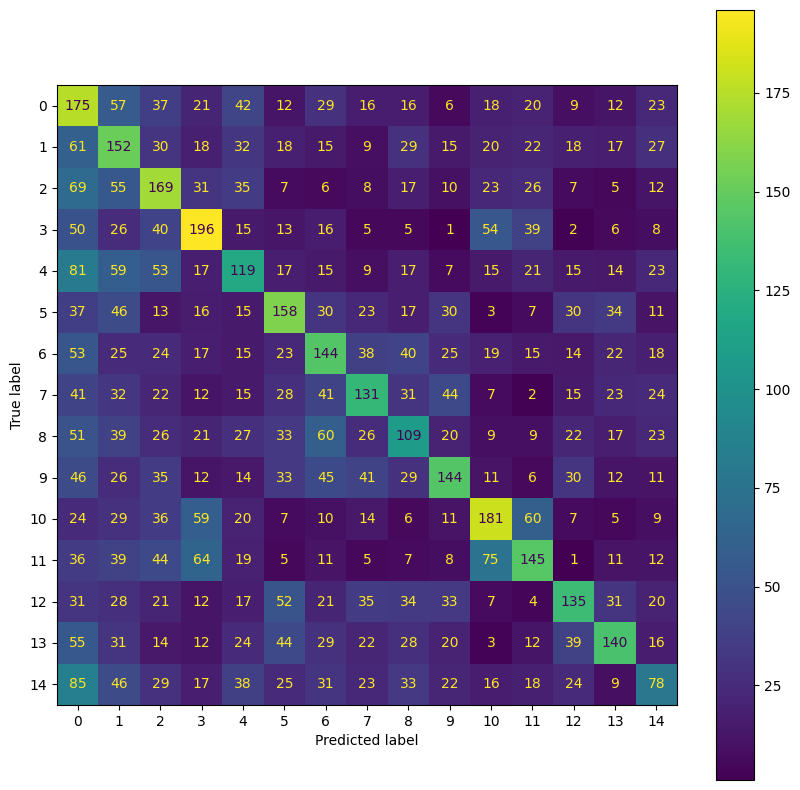

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_va.target.to_numpy(), y_pred, labels=rnd_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rnd_clf.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)


`A1`, `B1`, `C1`, `D1`, `E1`, `E2`, `E3`, `F1`, `G1`, `H1`, `I1`, `J1`, `K1`, `L1`, `M1`, `N1`, `REF`

In [66]:
X_va_inaccurate = X_va_freq[X_va_freq.true_pred==0]
X_va_inaccurate.columns

Index(['target', 'y_pred', 'true_pred', 'Frequency (GHz)'], dtype='object')

<Axes: ylabel='Frequency'>

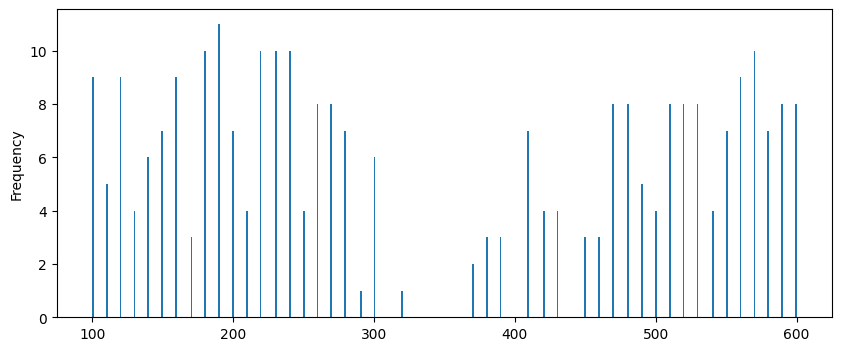

In [67]:
X_va_inaccurate[X_va_inaccurate.target == 3]['Frequency (GHz)'].plot.hist(bins=408,figsize=(10, 4))

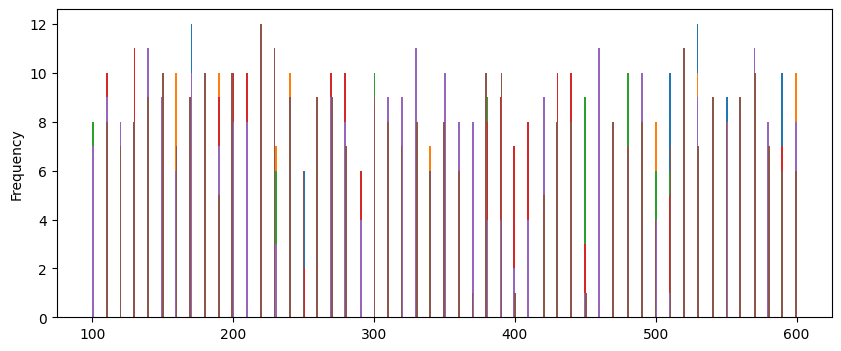

In [68]:
lst_target_with_bad_accuracy = [4, 6, 7, 9, 12, 13]

for t in lst_target_with_bad_accuracy:
    X_va_inaccurate[X_va_inaccurate.target == t]['Frequency (GHz)'].plot.hist(bins=408,figsize=(10, 4))

In [69]:
grouped = X_va_inaccurate["target"].groupby([X_va_inaccurate["target"],
                                             X_va_inaccurate["Frequency (GHz)"]
                                            ])
X_va_grouped = grouped.count()


In [70]:
%who

ConfusionMatrixDisplay	 DecisionTreeClassifier	 DummyClassifier	 GradientBoostingClassifier	 In	 KNeighborsClassifier	 LogisticRegression	 MultinomialNB	 OrdinalEncoder	 
Out	 RandomForestClassifier	 RidgeClassifier	 SGDClassifier	 SVC	 X_tr	 X_va	 X_va_freq	 X_va_freq_target	 
X_va_grouped	 X_va_inaccurate	 accuracy_score	 attributes	 ax	 balanced_train_ex	 bayes_score	 cm	 confusion_matrix	 
corr_matrix	 df_scores	 df_tmp	 dill	 disp	 dummy_clf	 dummy_score	 fig	 frequency	 
gb_clf	 gb_score	 group	 grouped	 label_train_ex	 logit_clf	 logit_score	 lst_accuracy_score	 lst_freq	 
lst_name_clf	 lst_target	 lst_target_with_bad_accuracy	 missing_val_count_by_column	 mode	 neigh_clf	 neigh_score	 np	 open	 
ordinal_encoder	 pd	 plt	 reduce_to_mode	 ridge_clf	 ridge_score	 rnd_clf	 rnd_score	 run_time	 
scatter_matrix	 sgd_clf	 sgd_score	 start_time	 svc_clf	 svc_score	 t	 target	 test_set	 
time	 tmp_balanced_data	 train	 train_ex	 train_mo	 train_pr	 train_set	 train_sol	 train_test_split